# Strain Rate walkthrough
Though other notebooks have calculated vertical displacements and gave some rough stabs at strain rates, this notebook will formally walk through the process step-by-step, with large data sets.

In [1]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../xapres/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    20:23:39 	 ApRESDefs.py @function _setup_logging line 539 - Stream logging level set to DEBUG
DEBUG    20:23:39 	 ApRESDefs.py @function _setup_logging line 540 - Add console handler to logger
DEBUG    20:23:39 	 ApRESDefs.py @function _setup_logging line 553 - File logging level set to DEBUG


In [2]:
# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35255")
client

<Client: 'tcp://127.0.0.1:35255' processes=1 threads=4, memory=31.45 GiB>

In [3]:
# Loading site data - we use station 101 for now
def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_summer = reload_summer("A101")
ds_winter = reload_winter("A101")



Trim these datasets down to the chirps at the relevant attenuation setting and to relevant times (i.e. remove first couple test bursts). We choose the lower gain settings since those are the only settings consistent across the seasons (only for A101). We recognize there are clipping artifacts, so we will calculate stacked profiles using the second half of each chirp. 

In [4]:
# use pair 1 for A101, 0 for A103 and A104
ds_s = ds_summer.chirp.isel(attenuator_setting_pair=1,time=range(100,len(ds_summer.time)))
ds_w = ds_winter.chirp.isel(attenuator_setting_pair=1)

In [5]:
# define custom profile function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

Note: we should have this script built into our package.

In [6]:
da_s_stacked  = custom_stacked_profile_series(ds_s,2,3e8,4e8)
print('Done Summer')
da_w_stacked  = custom_stacked_profile_series(ds_w,2,3e8,4e8)
print('Done Winter')

Done Summer
Done Winter


Now that we have these custom profiles, lets first plot them together. We can concatenate them.

In [7]:
profile_full = xr.concat([da_s_stacked,da_w_stacked],'time')

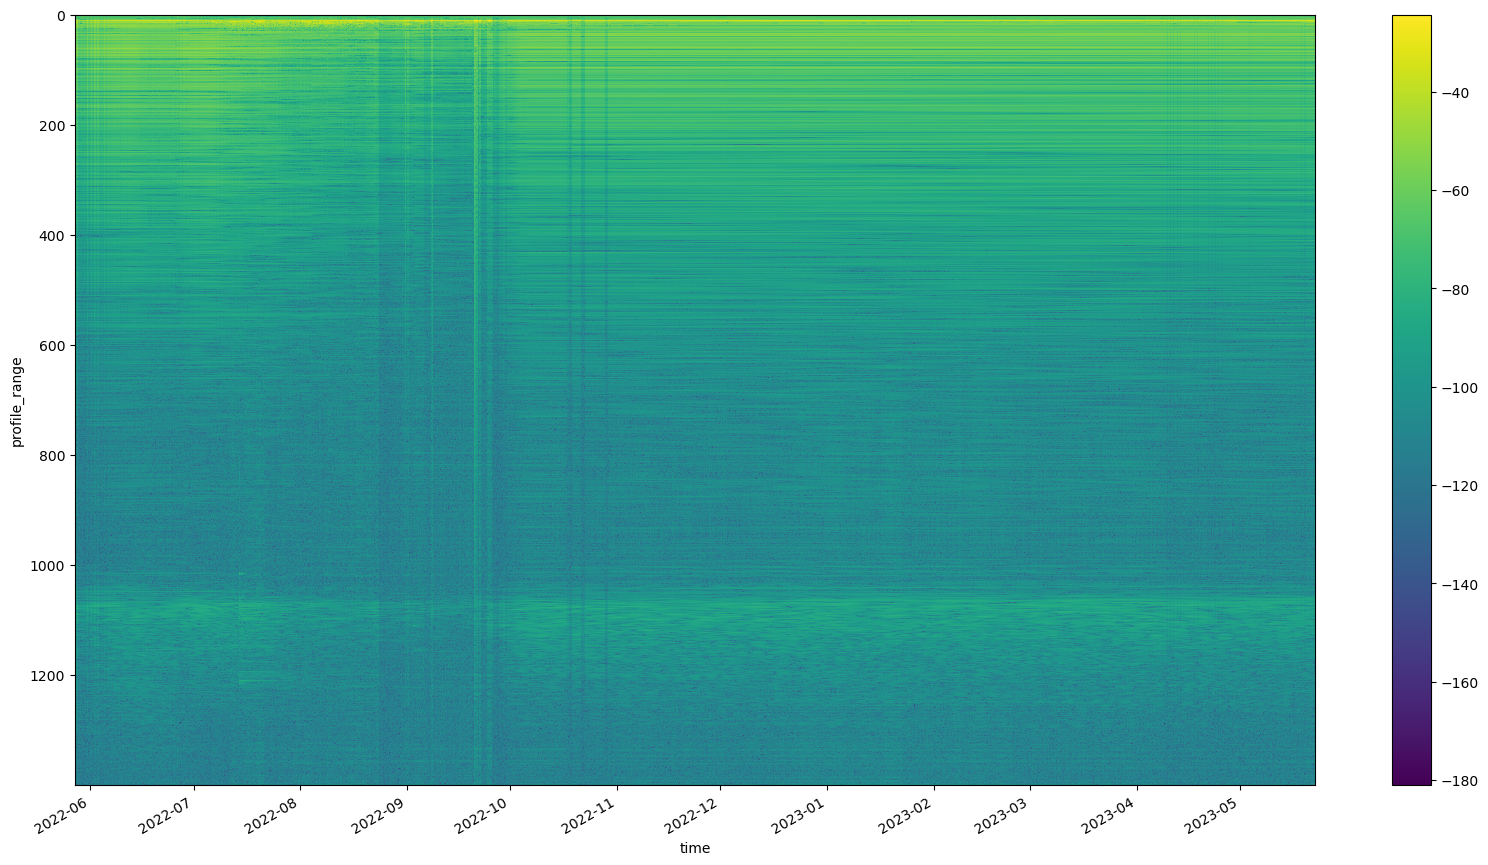

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

ds = xa.dB(profile_full)
ds.plot(ax=ax,x='time')
ax.invert_yaxis()

Now onto the velocities. We need to duplicate the dataset to compare each burst pair.

In [9]:
b1 = profile_full.isel(time=range(0,len(profile_full.time)-1)).where(profile_full.profile_range >= 10,drop=True)
b2 = profile_full.isel(time=range(1,len(profile_full.time))).where(profile_full.profile_range >= 10,drop=True)

In [10]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     20:32:34 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [901. 900. 901. ... 901. 900. 901.]s


Plotting displacement between burst pairs:

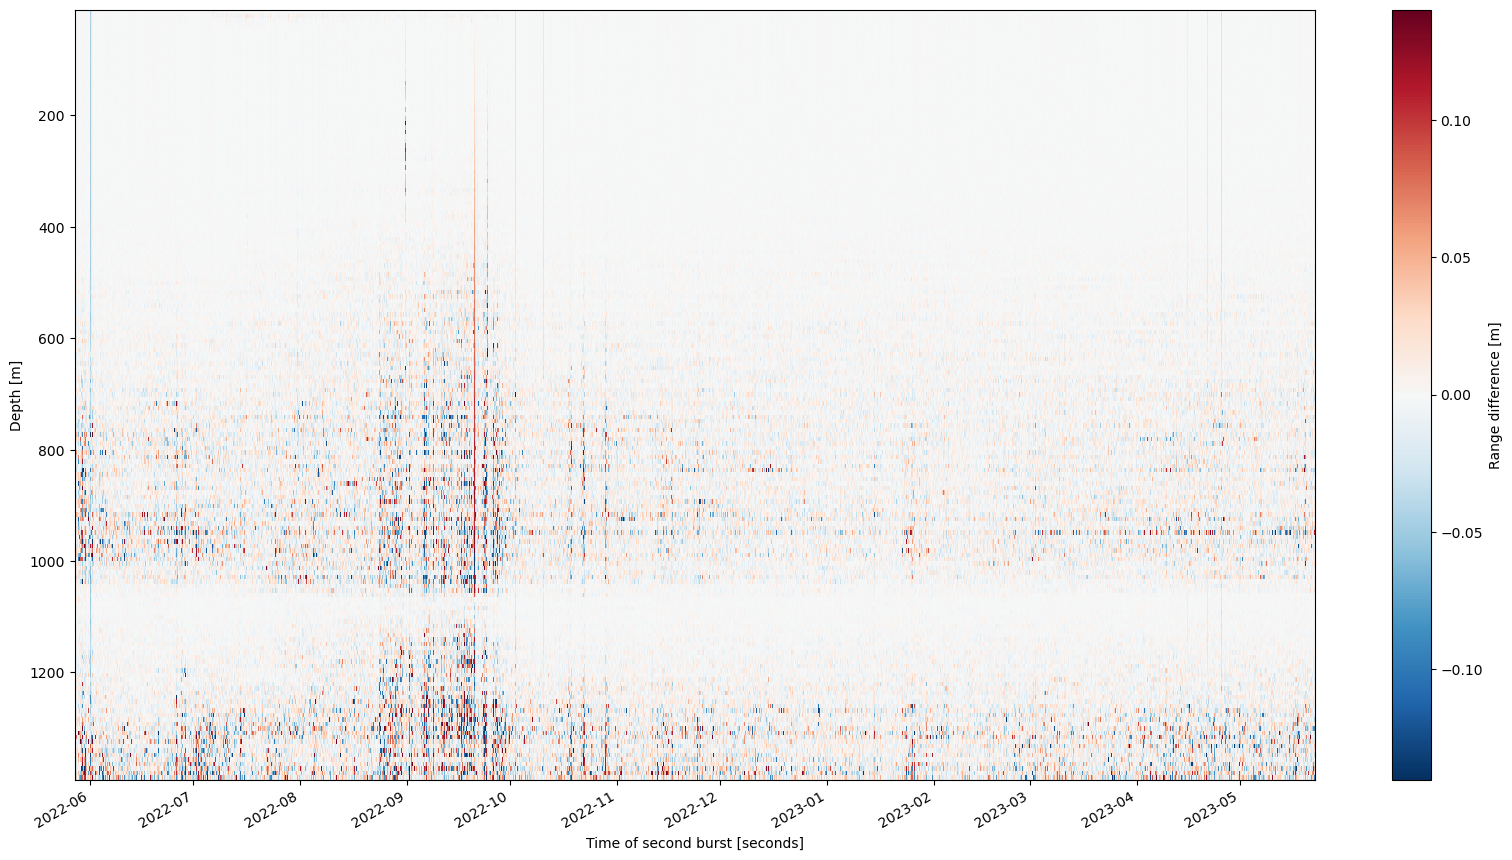

In [11]:
fig, ax = plt.subplots(figsize=(20,10))

ds.range_diff.plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

Plotting total displacement 

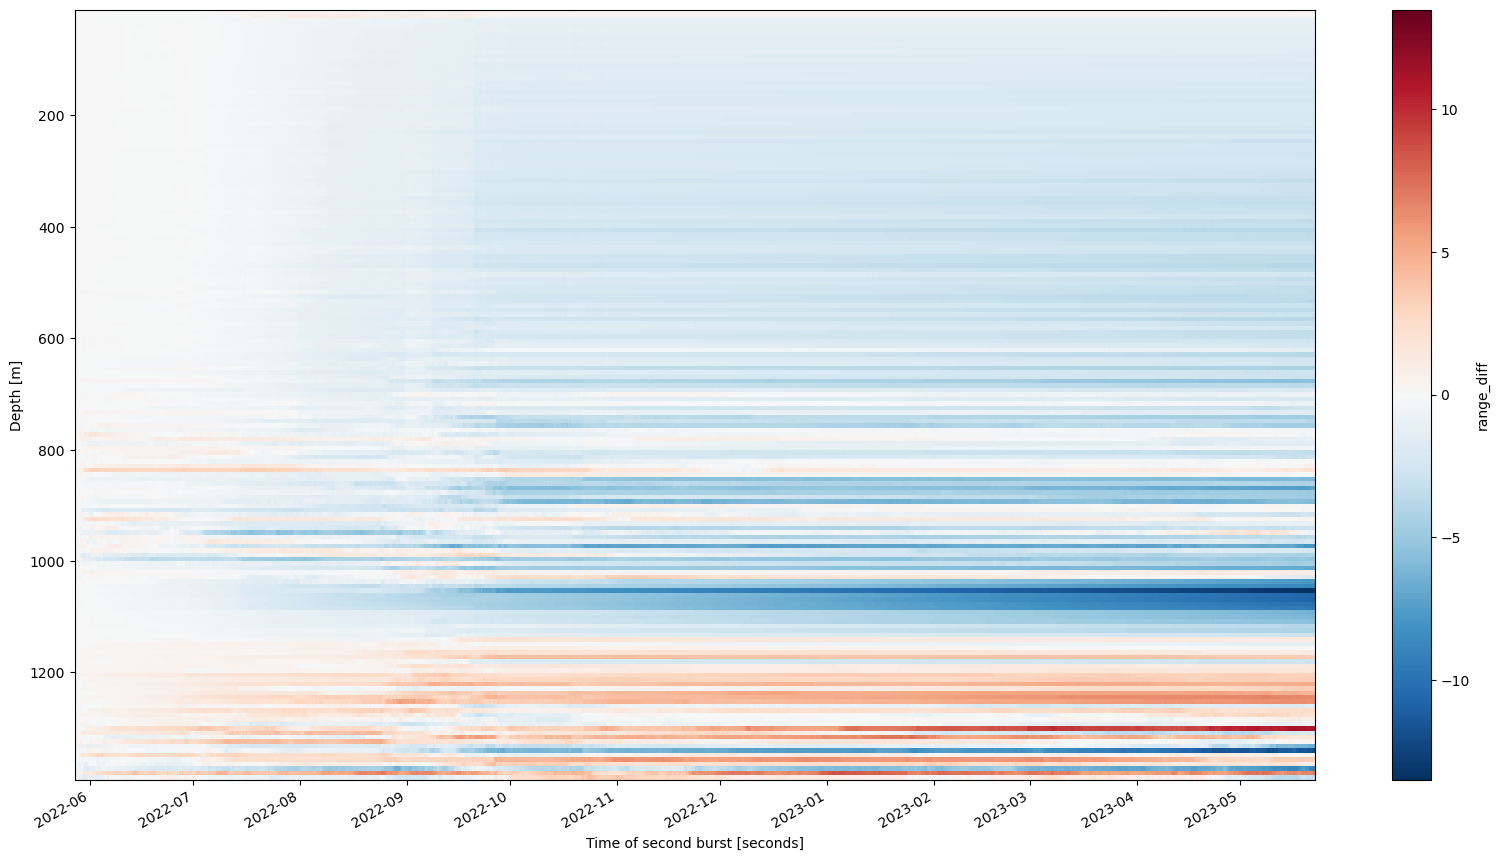

In [12]:
fig, ax = plt.subplots(figsize=(20,10))

ds.range_diff.cumsum(dim='time').plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

Vertical strain rate is the change in vertical velocity in the z direction. Consequently taking the gradient of the displacement pairs (not the cumulative sums) essentialy gives us the strain rate.

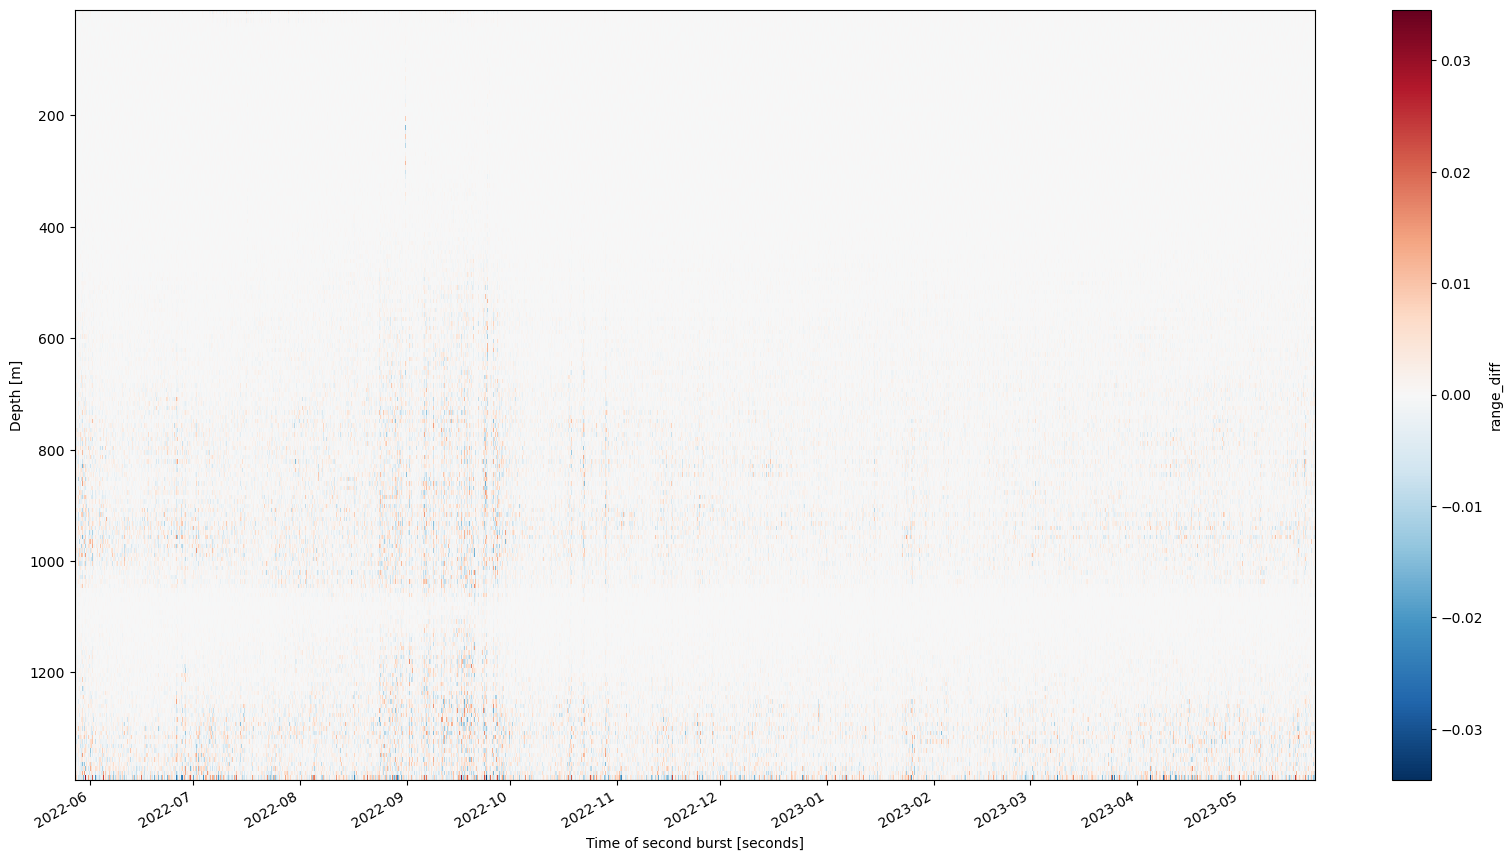

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
strain_rates = ds.range_diff.differentiate('profile_range')
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

Nothing too significant seems like. The background displacement is removed though.

Let's try looking at a window where we know something happened

In [14]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='15T')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')

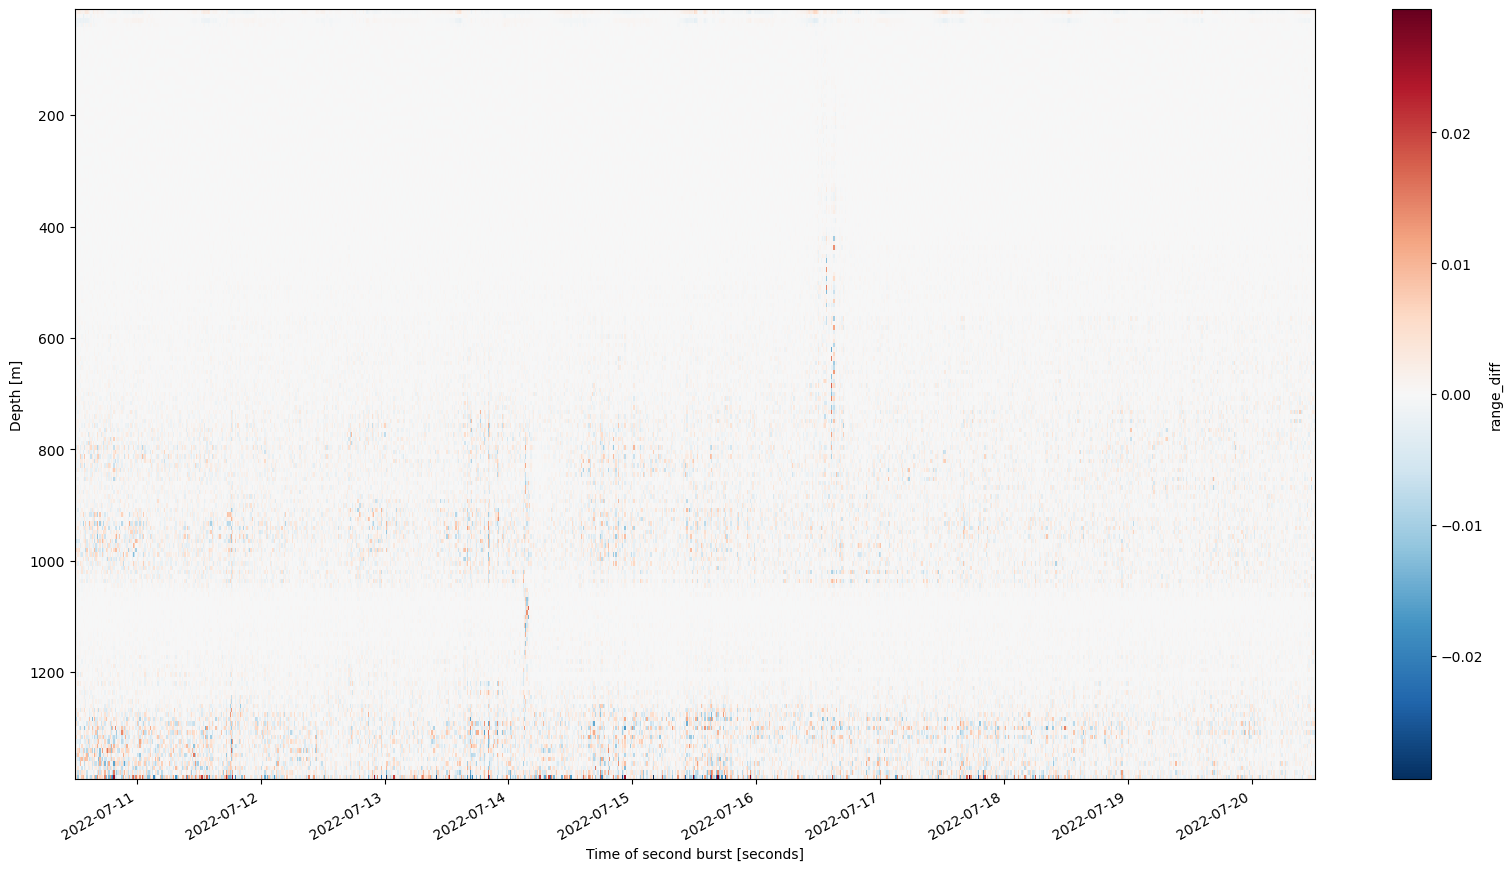

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

In [16]:
strain_rates_resample

<xarray.DataArray 'range_diff' (time: 961, profile_range: 173)>
array([[-1.67482480e-04, -9.85602378e-04, -4.91178587e-04, ...,
        -8.50017535e-03, -3.07381119e-04,  1.54182934e-02],
       [ 8.23981189e-04,  3.01942117e-05, -7.68489627e-04, ...,
         6.27073811e-04,  2.07703826e-03,  5.57105622e-03],
       [ 1.93846464e-03,  5.72479691e-04, -1.45661360e-03, ...,
         3.64274632e-03, -6.76231489e-03, -1.09851539e-02],
       ...,
       [-4.08083307e-04, -3.60976631e-04,  1.47054376e-04, ...,
        -8.20728891e-04, -5.38378582e-04,  3.40195544e-03],
       [ 2.27068432e-04, -1.61602743e-04, -1.05422838e-04, ...,
        -6.39250581e-04, -1.04411227e-03, -3.01948746e-03],
       [ 1.08307032e-03,  5.57376283e-04, -4.36383972e-04, ...,
        -2.10516926e-03, -1.04709949e-03,  2.88979690e-03]])
Coordinates:
  * time           (time) datetime64[ns] 2022-07-10T12:06:52 ... 2022-07-20T1...
  * profile_range  (profile_range) float64 13.88 21.87 ... 1.38e+03 1.388e+03

Again, seems like not that much happens. What looks significant in this window looks the same as what looks like noise in September and October.

(-0.001, 0.001)

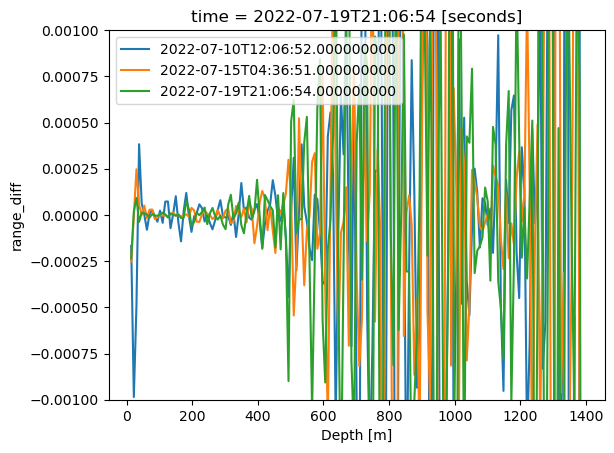

In [17]:
for i in [0,450,900]:
    strain_rates_resample.isel(time=i).plot(label=strain_rates_resample.time.isel(time=i).values)
plt.legend()
plt.ylim([-1e-3,1e-3])

# Testing stacking

We are going to first try stacking each burst into hourly profiles.

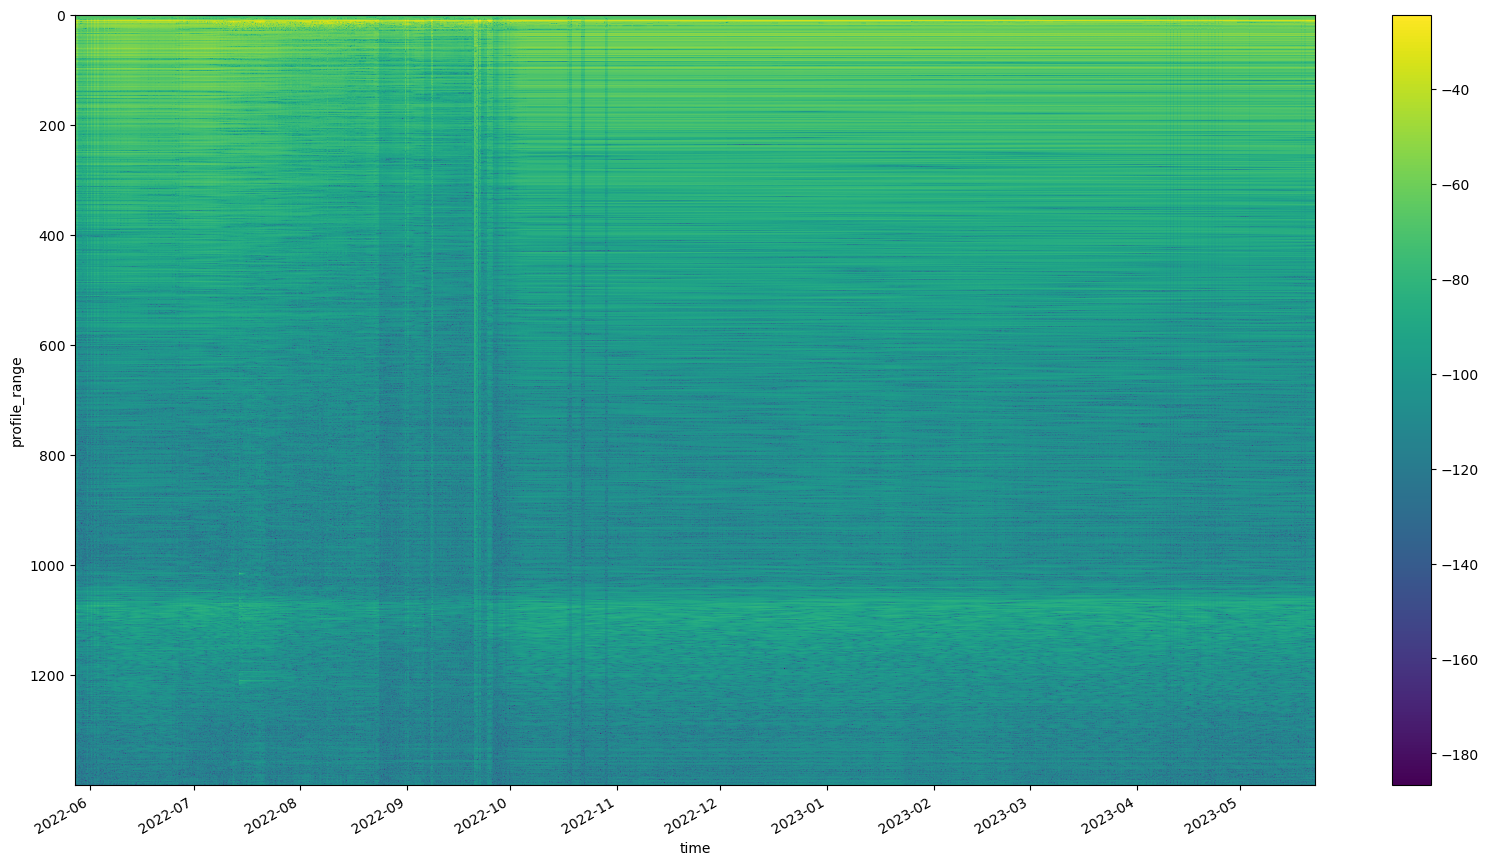

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
profile_hourly = profile_full.resample(time='1H').mean(dim='time')
ds = xa.dB(profile_hourly)
ds.plot(ax=ax,x='time')
ax.invert_yaxis()

In [19]:
b1 = profile_hourly.isel(time=range(0,len(profile_hourly.time)-1)).where(profile_hourly.profile_range >= 10,drop=True)
b2 = profile_hourly.isel(time=range(1,len(profile_hourly.time))).where(profile_hourly.profile_range >= 10,drop=True)

In [20]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     20:33:55 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [3600. 3600. 3600. ... 3600. 3600. 3600.]s


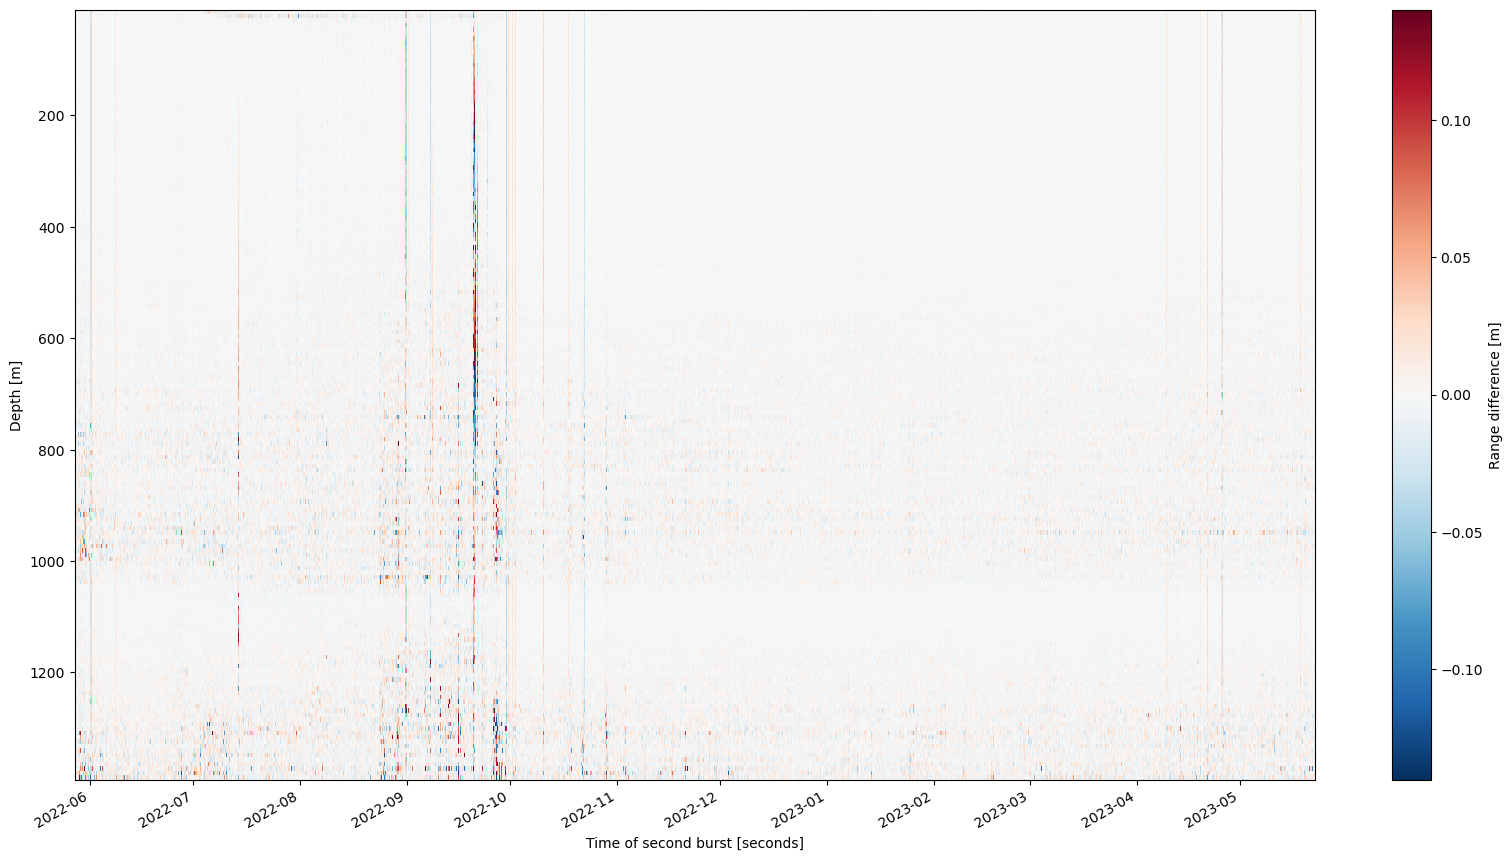

In [21]:
fig, ax = plt.subplots(figsize=(20,10))

ds.range_diff.plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

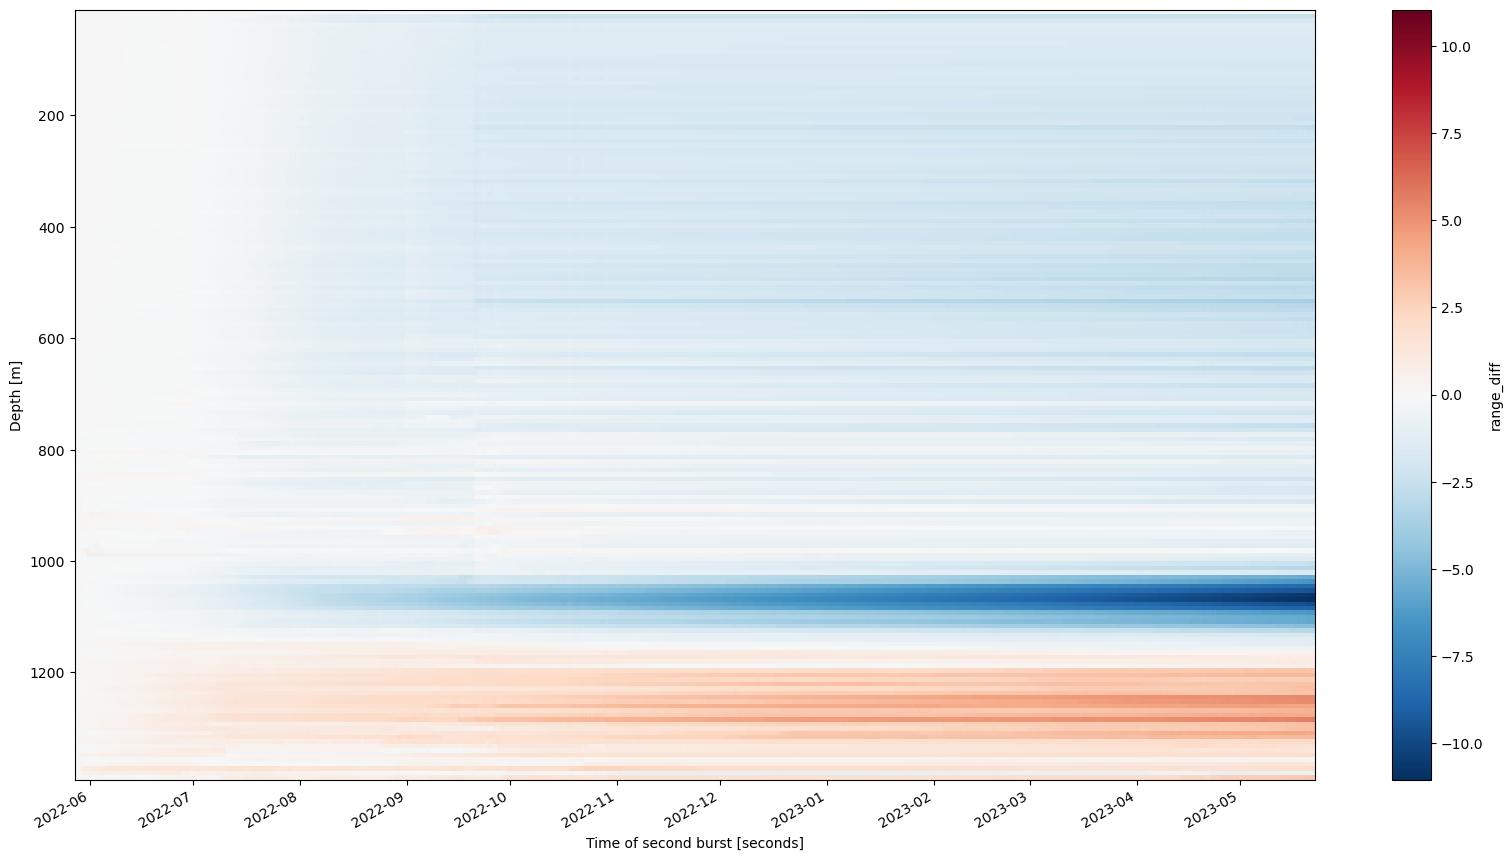

In [22]:
fig, ax = plt.subplots(figsize=(20,10))

ds.range_diff.cumsum(dim='time').plot(ax=ax,x='time',cmap='RdBu_r')
ax.invert_yaxis()

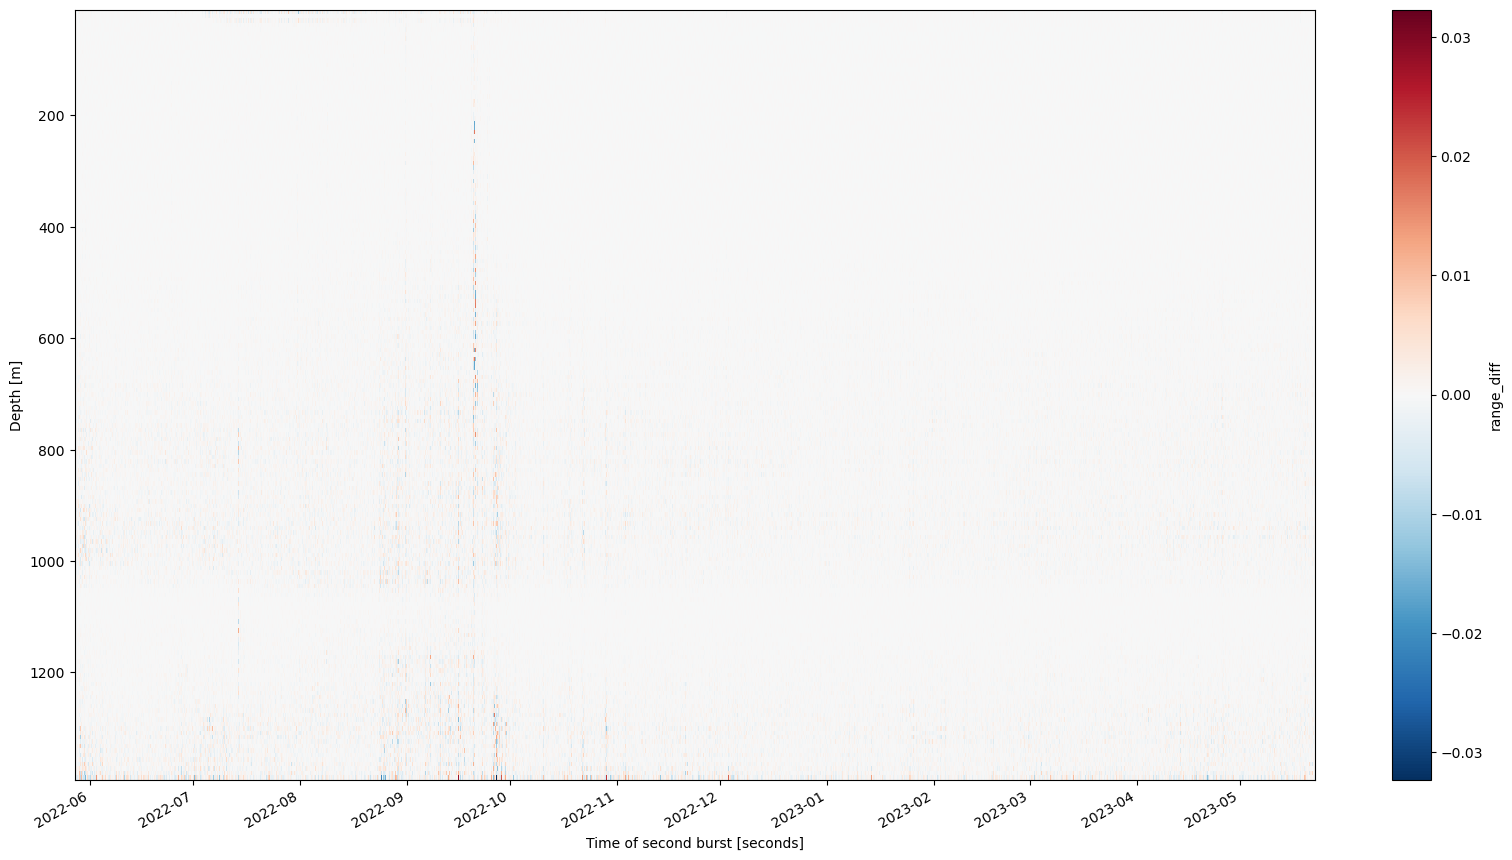

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
strain_rates = ds.range_diff.differentiate('profile_range')
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

In [24]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='1H')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')

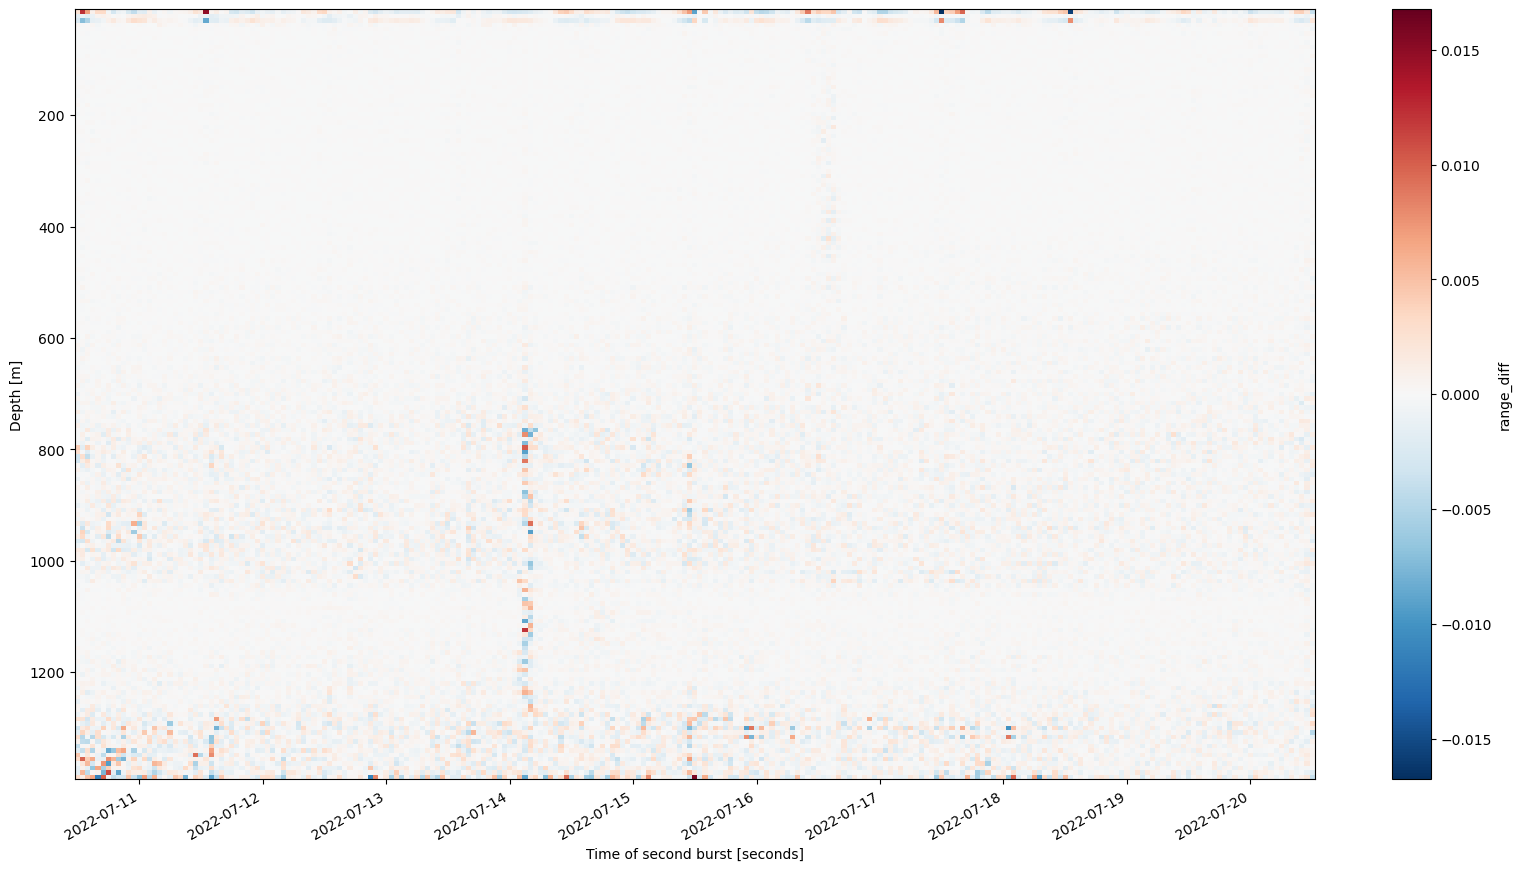

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

Now let's just try increasing until we reach 1 day

INFO     20:34:16 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [7200. 7200. 7200. ... 7200. 7200. 7200.]s


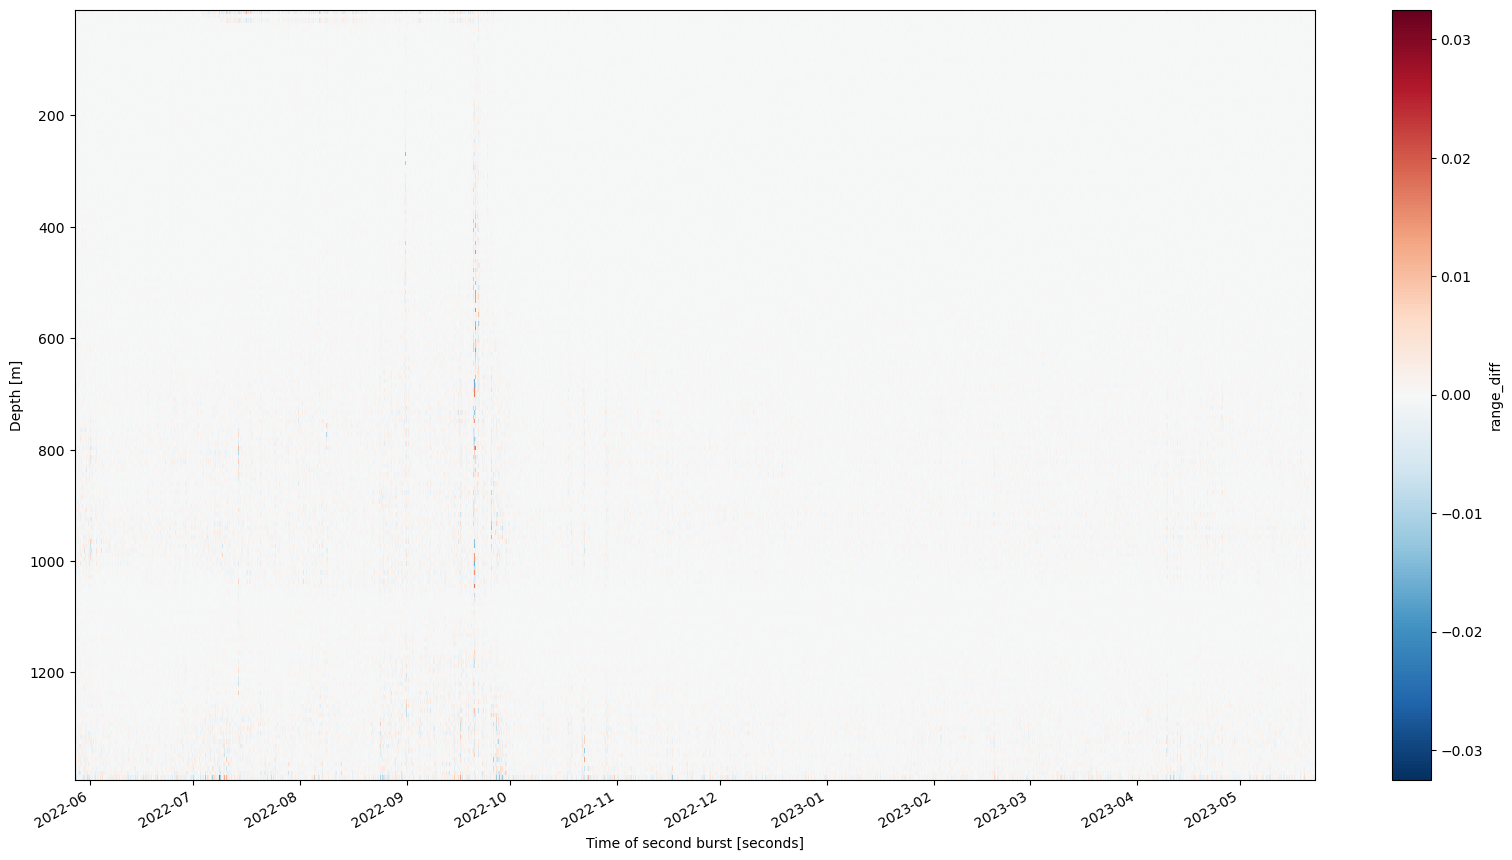

In [26]:
# 2hour 
profile_resample = profile_full.resample(time='2H').mean(dim='time')
b1 = profile_resample.isel(time=range(0,len(profile_resample.time)-1)).where(profile_resample.profile_range >= 10,drop=True)
b2 = profile_resample.isel(time=range(1,len(profile_resample.time))).where(profile_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)
strain_rates = ds.range_diff.differentiate('profile_range')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

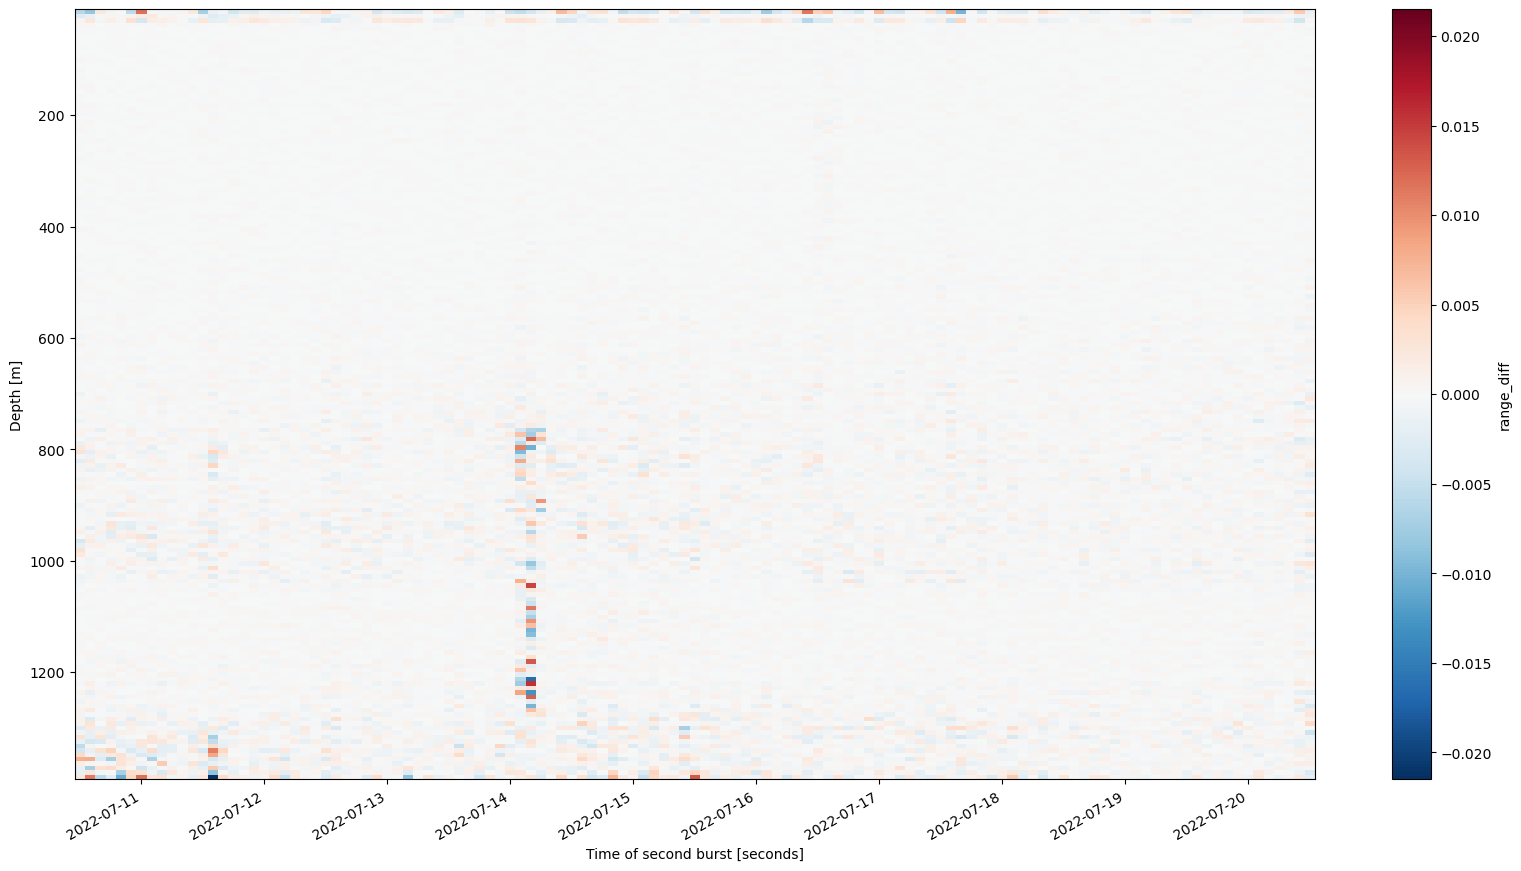

In [27]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='2H')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

Double again

INFO     20:34:28 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [14400. 14400. 14400. ... 14400. 14400. 14400.]s


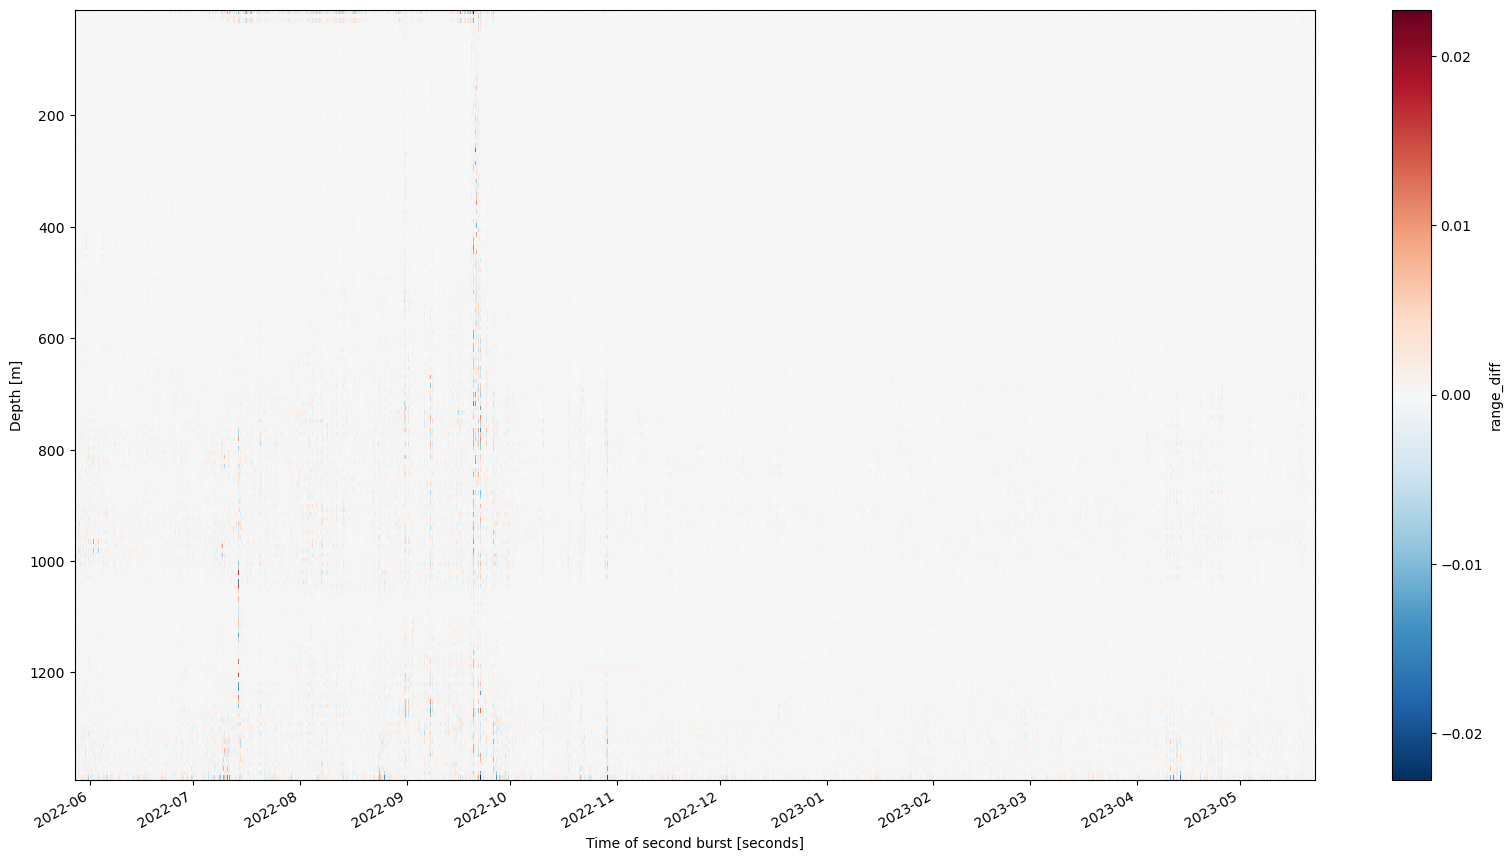

In [28]:
# 4hour 
profile_resample = profile_full.resample(time='4H').mean(dim='time')
b1 = profile_resample.isel(time=range(0,len(profile_resample.time)-1)).where(profile_resample.profile_range >= 10,drop=True)
b2 = profile_resample.isel(time=range(1,len(profile_resample.time))).where(profile_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)
strain_rates = ds.range_diff.differentiate('profile_range')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

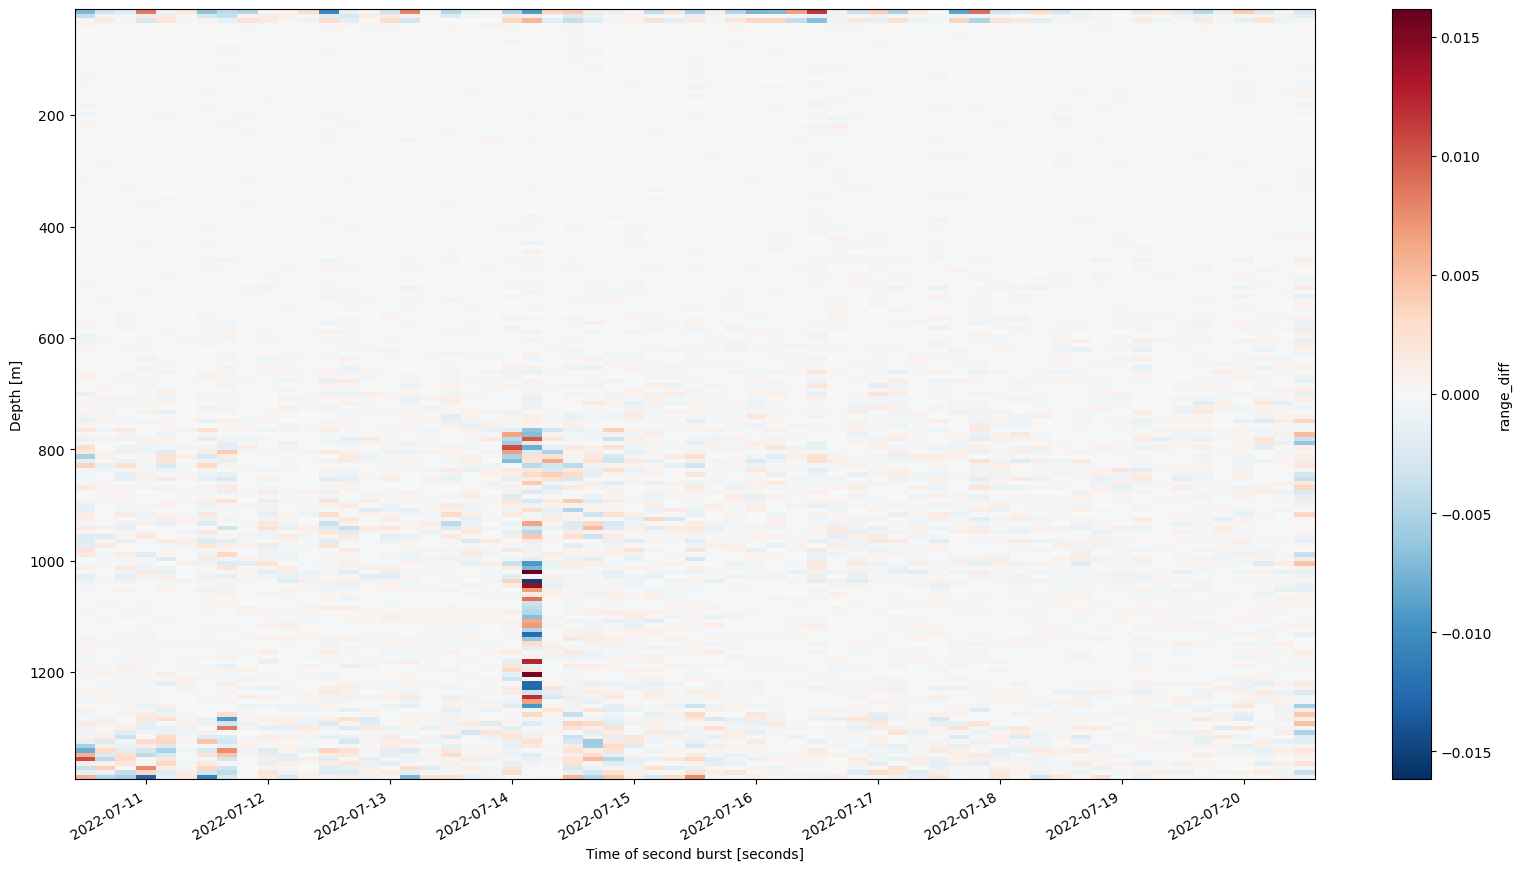

In [29]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='4H')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

And double again

INFO     20:34:37 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [28800. 28800. 28800. ... 28800. 28800. 28800.]s


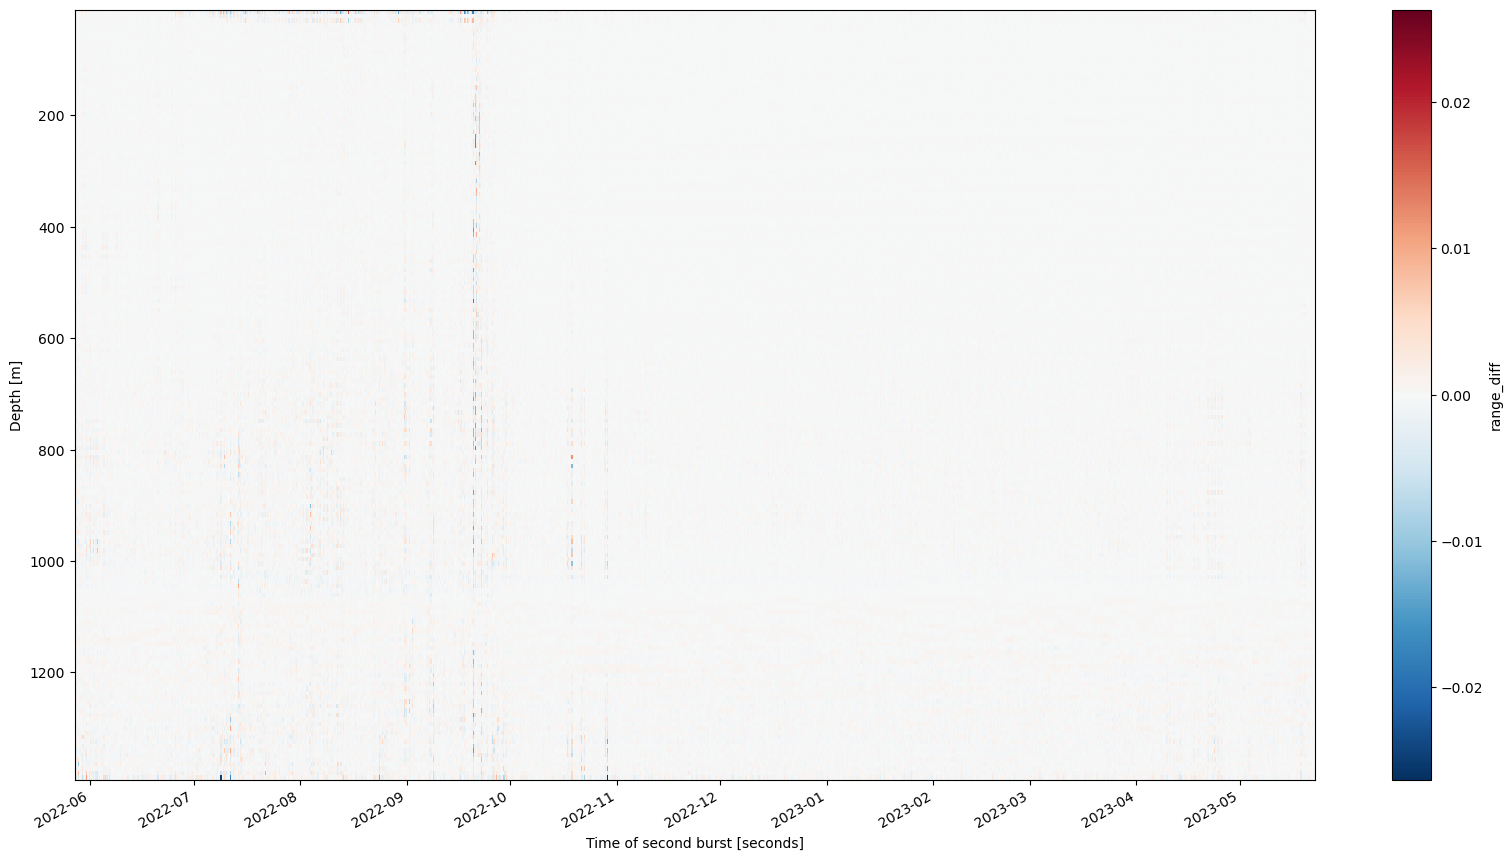

In [30]:
# 8 hour 
profile_resample = profile_full.resample(time='8H').mean(dim='time')
b1 = profile_resample.isel(time=range(0,len(profile_resample.time)-1)).where(profile_resample.profile_range >= 10,drop=True)
b2 = profile_resample.isel(time=range(1,len(profile_resample.time))).where(profile_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)
strain_rates = ds.range_diff.differentiate('profile_range')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

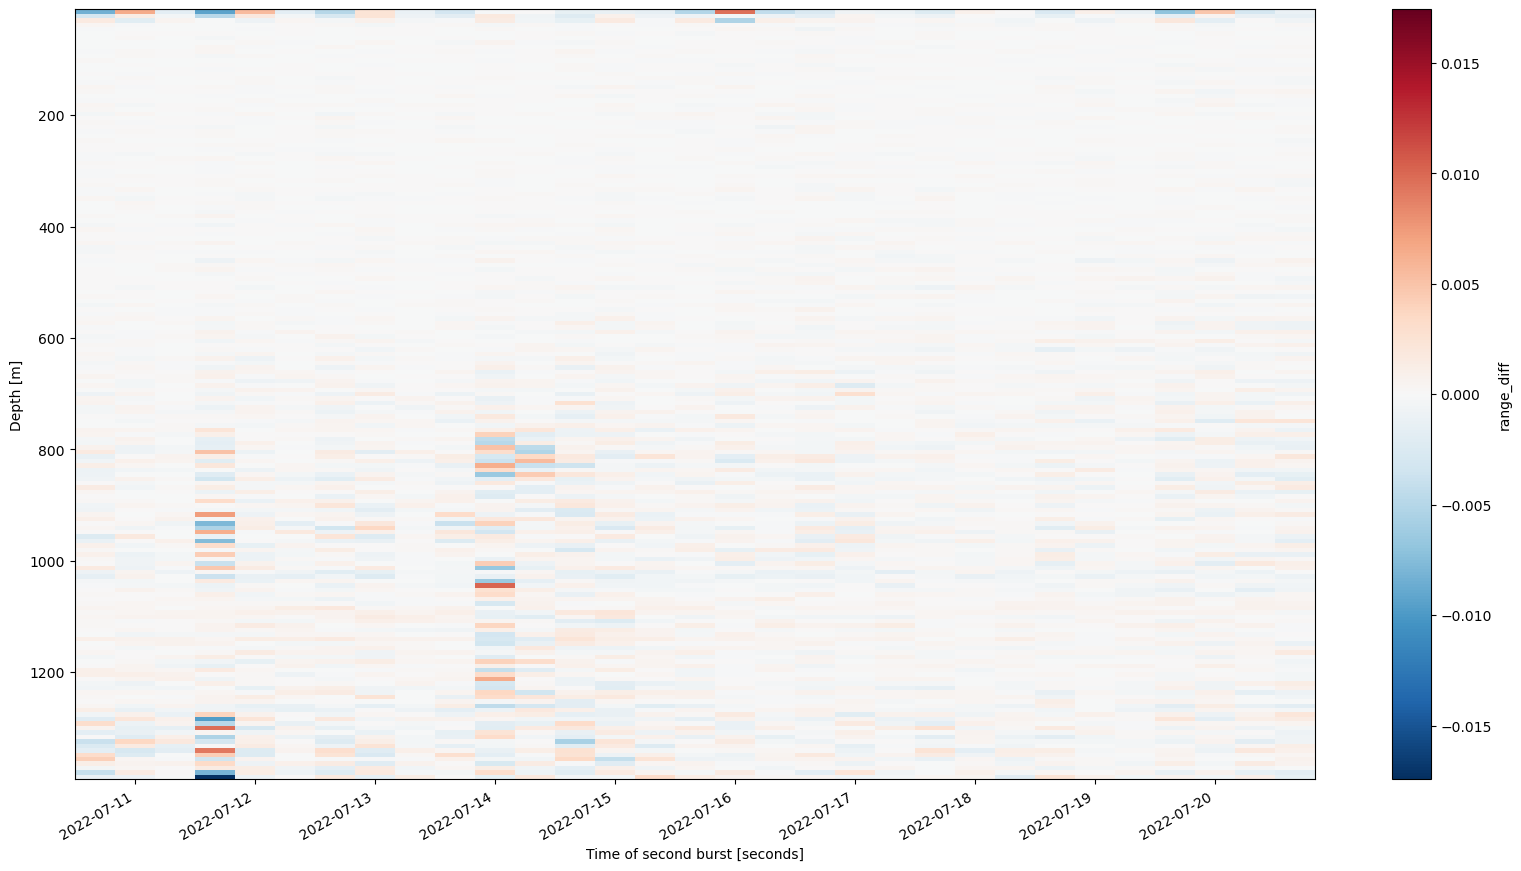

In [31]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='8H')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

Bump up to 12 hours

INFO     20:34:46 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43200.
 43200. 43200. 43200. 43200. 43200. 43200. 43200. 43

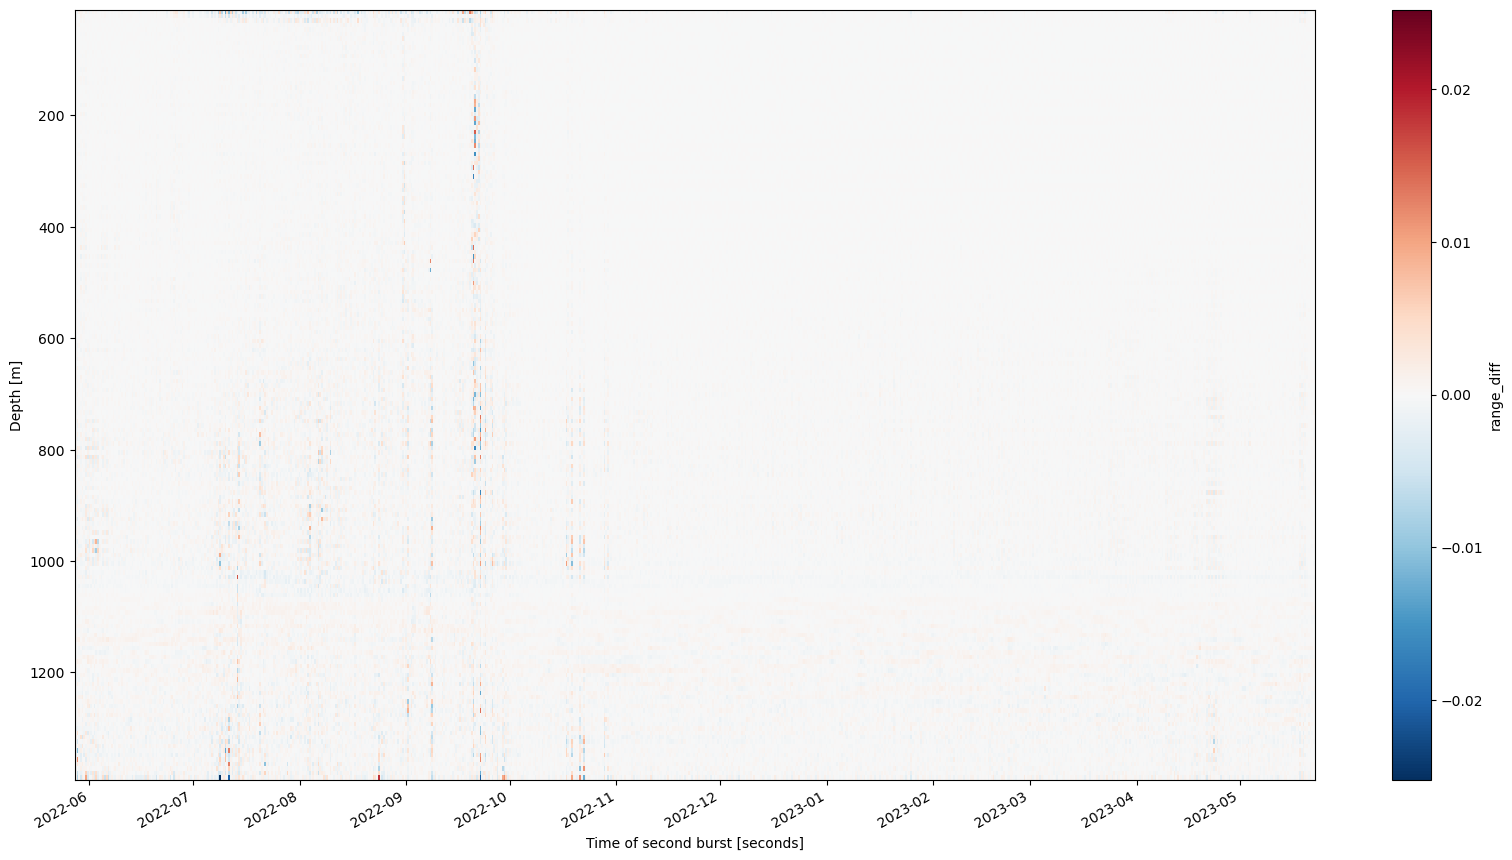

In [32]:
# 12 hour 
profile_resample = profile_full.resample(time='12H').mean(dim='time')
b1 = profile_resample.isel(time=range(0,len(profile_resample.time)-1)).where(profile_resample.profile_range >= 10,drop=True)
b2 = profile_resample.isel(time=range(1,len(profile_resample.time))).where(profile_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)
strain_rates = ds.range_diff.differentiate('profile_range')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

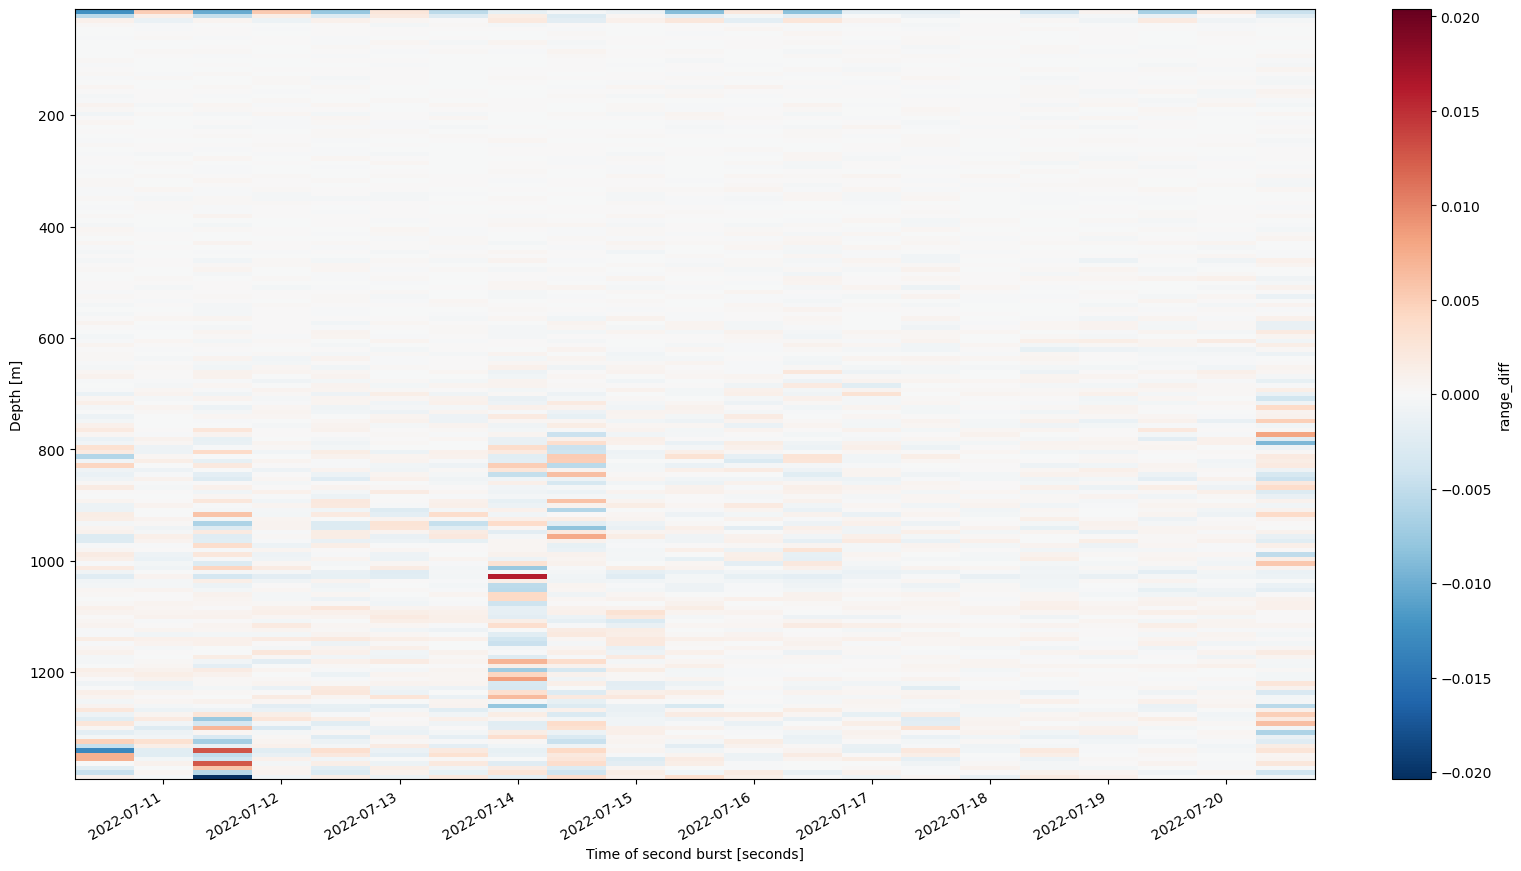

In [33]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='12H')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

Looks a bit noisier. Let's try entire days.

INFO     20:34:54 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86400.
 86400. 86400. 86400. 86400. 86400. 86400. 86400. 86

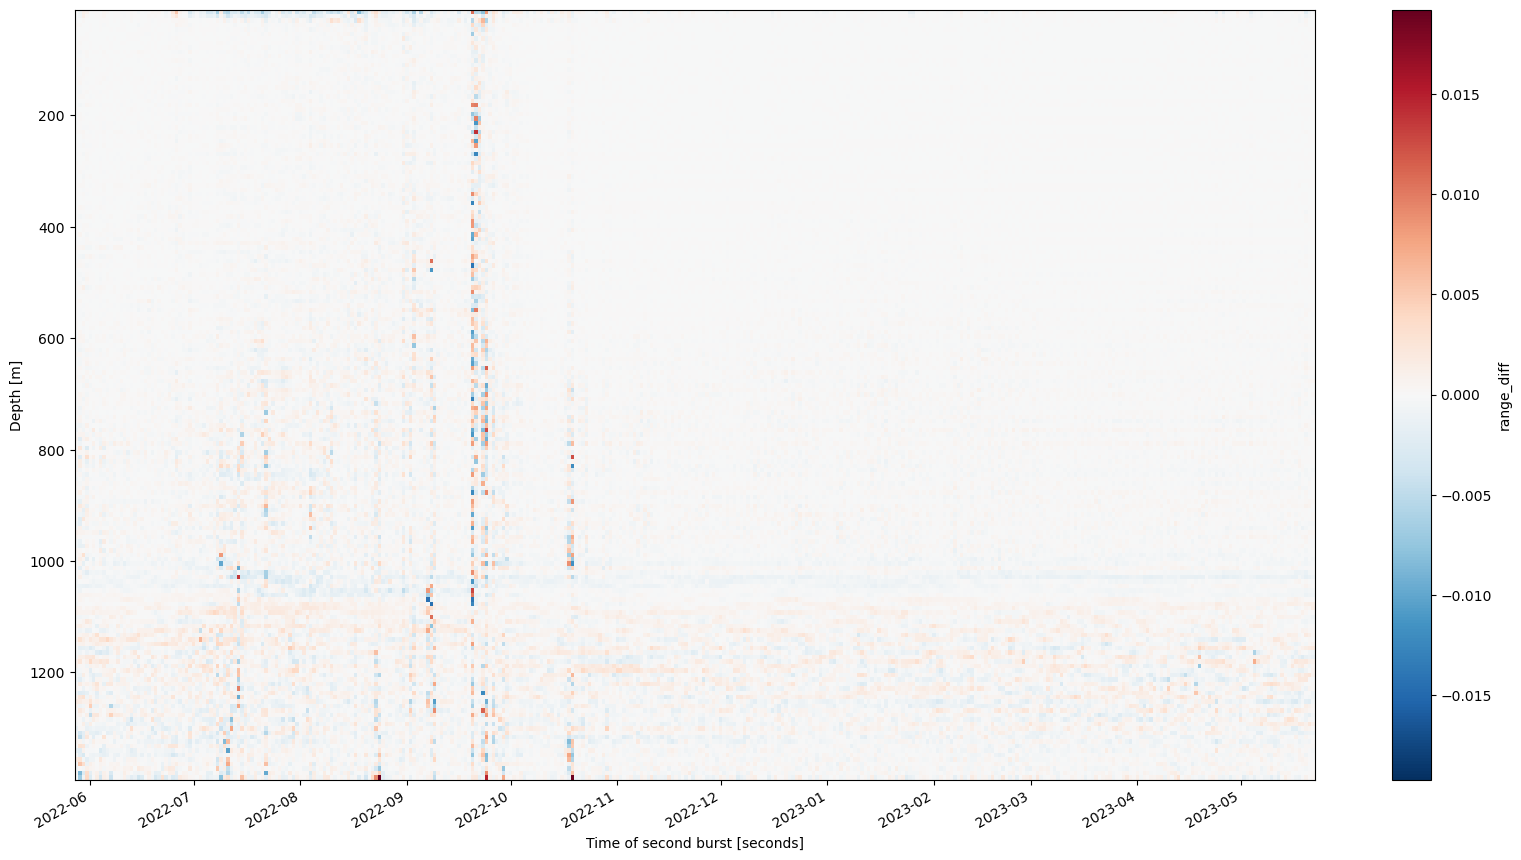

In [34]:
# Daily
# 12 hour 
profile_resample = profile_full.resample(time='1D').mean(dim='time')
b1 = profile_resample.isel(time=range(0,len(profile_resample.time)-1)).where(profile_resample.profile_range >= 10,drop=True)
b2 = profile_resample.isel(time=range(1,len(profile_resample.time))).where(profile_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)
strain_rates = ds.range_diff.differentiate('profile_range')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

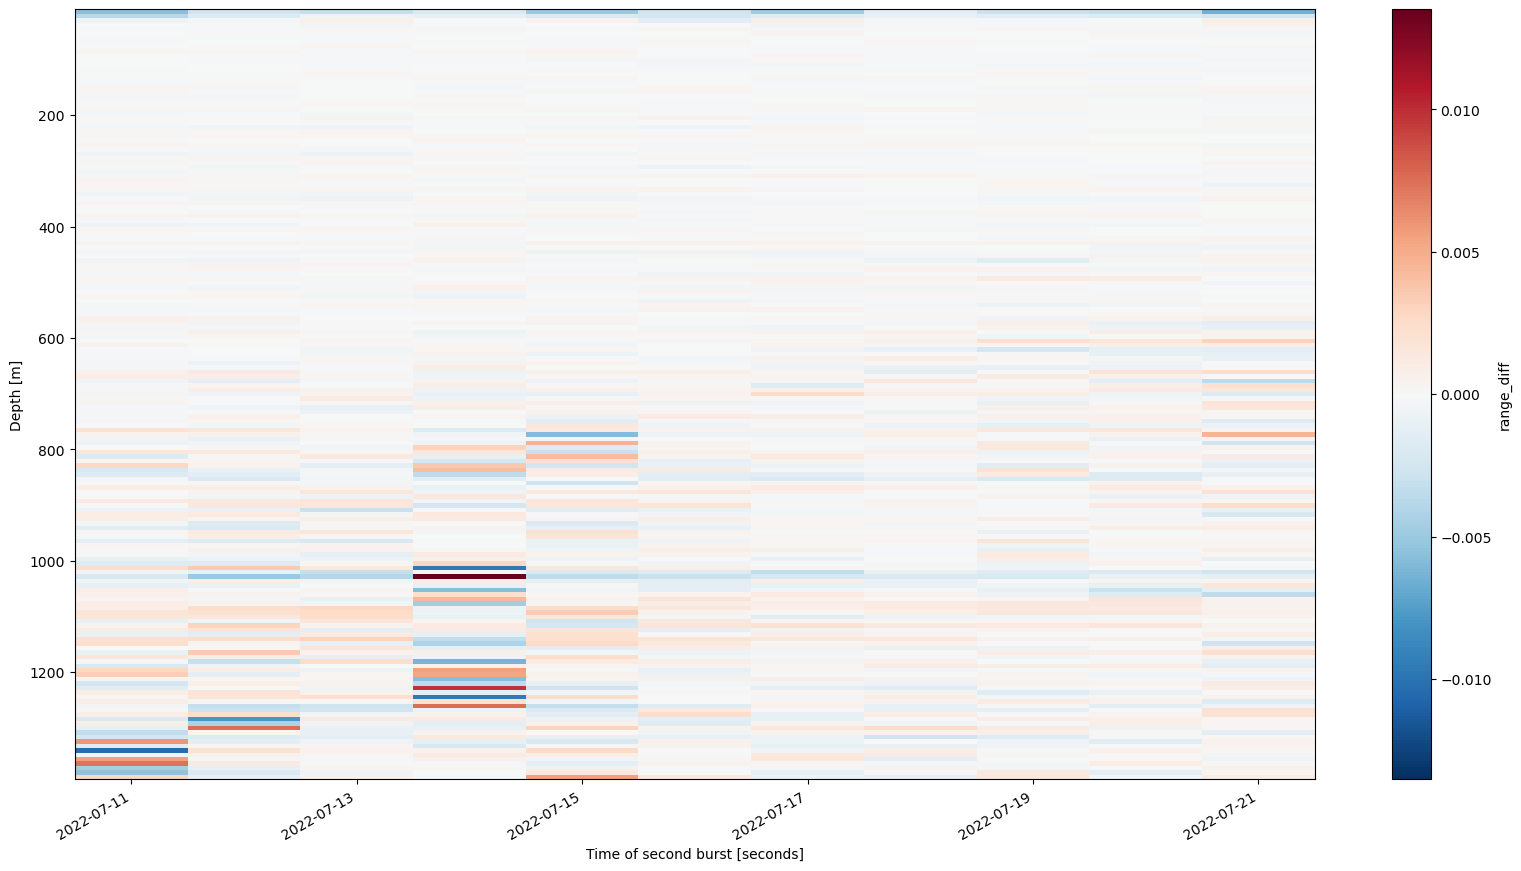

In [35]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='1D')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

4 hour one looks nicest probably

# Testing skipping measurements in strain rate calculations

In [36]:
profile_resample = profile_full.resample(time='1H').mean(dim='time')


INFO     20:35:04 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [7200. 7200. 7200. ... 7200. 7200. 7200.]s


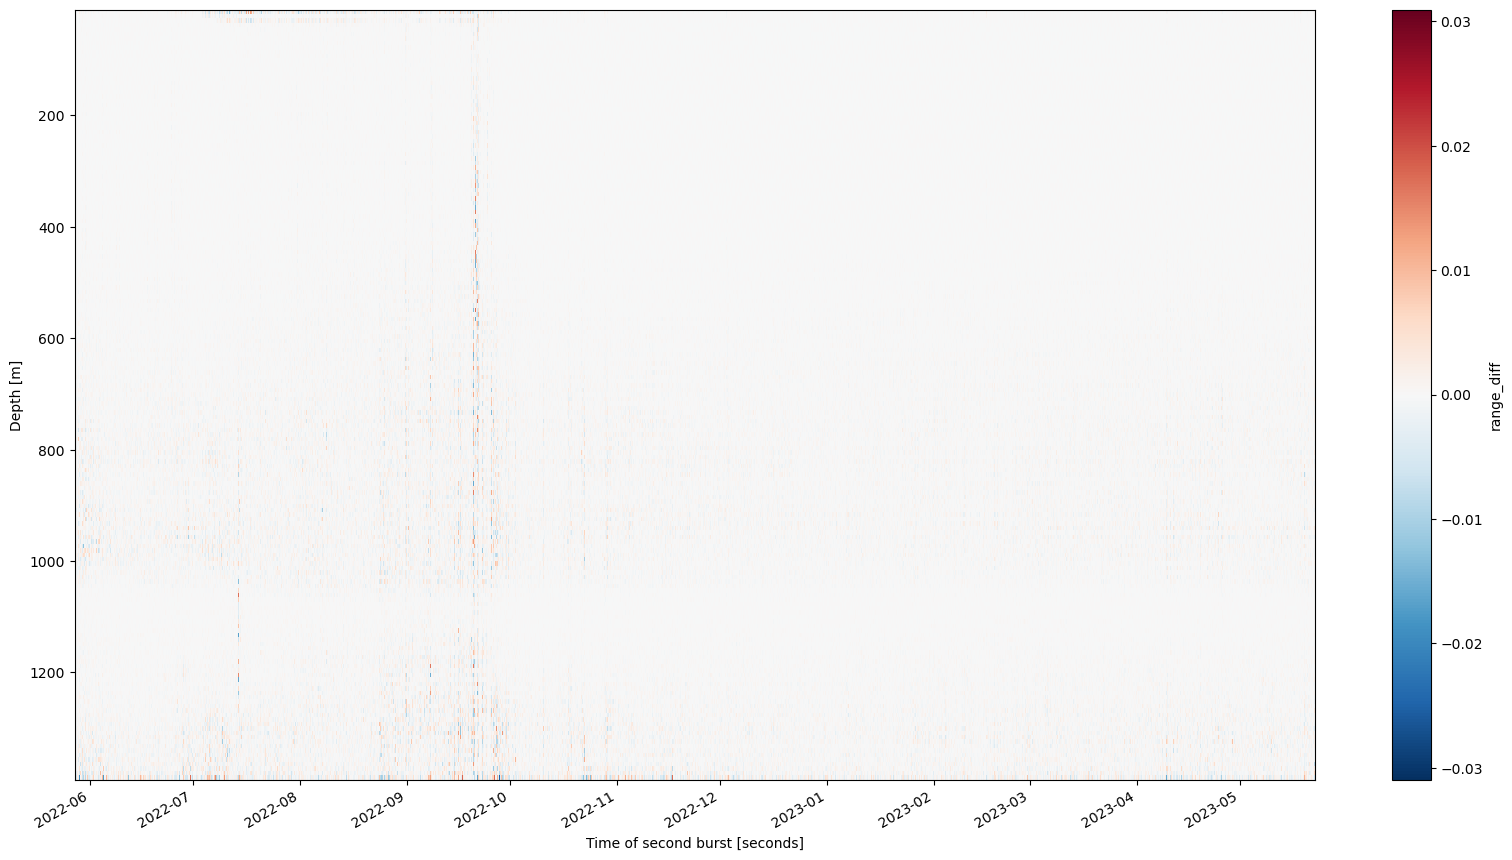

In [37]:
# calculate strain rate from stacks 2 hours apart
b1 = profile_resample.isel(time=range(0,len(profile_resample.time)-2)).where(profile_resample.profile_range >= 10,drop=True)
b2 = profile_resample.isel(time=range(2,len(profile_resample.time))).where(profile_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)
strain_rates = ds.range_diff.differentiate('profile_range')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()

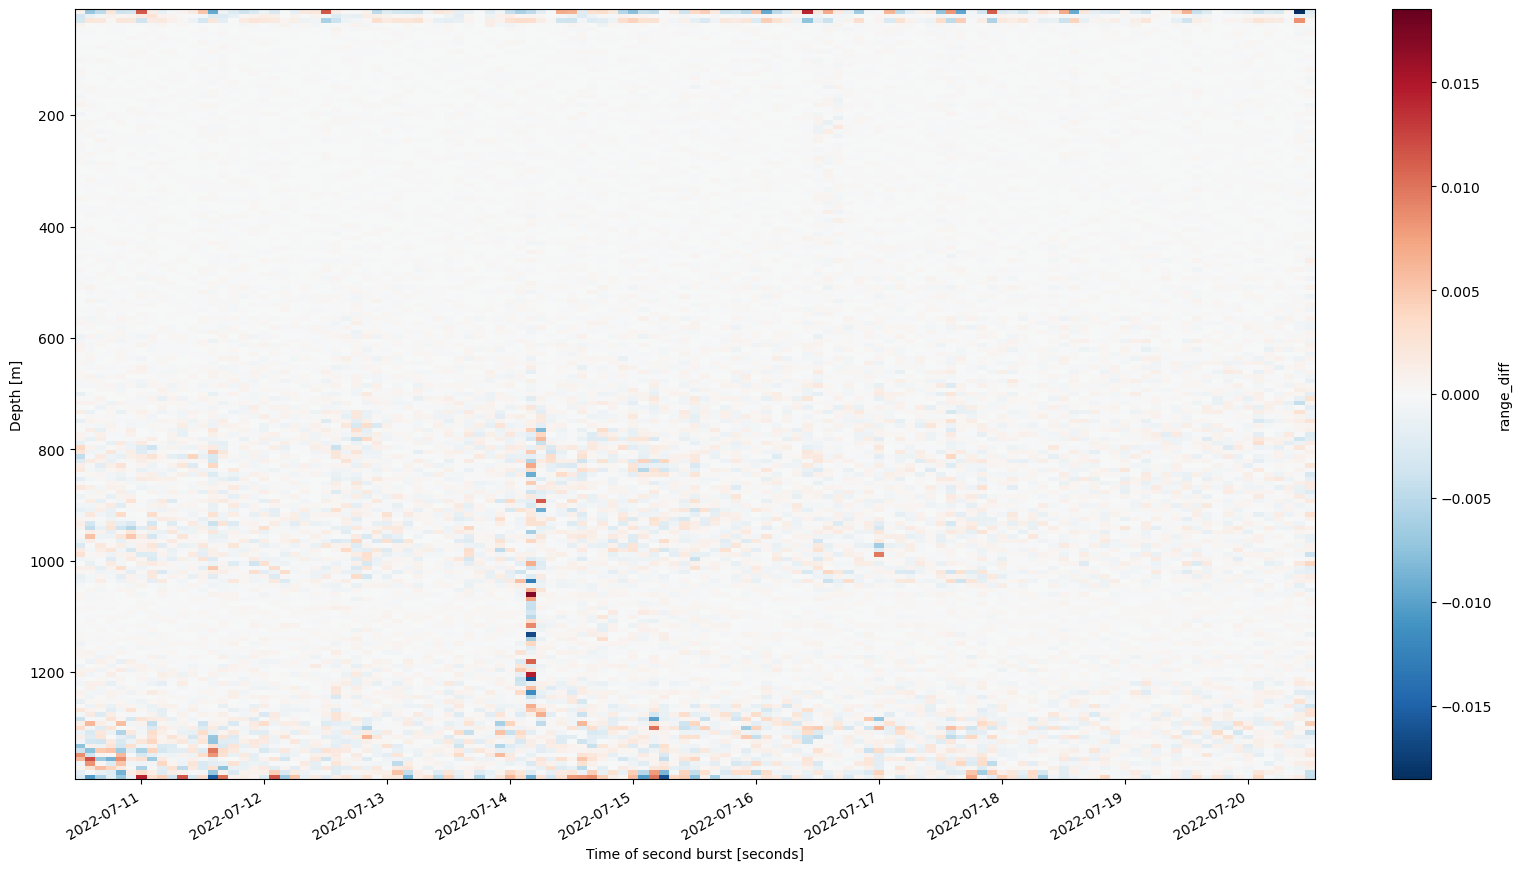

In [38]:
date_range = xr.date_range('2022-07-10T12:00:00.000000000','2022-07-20T12:00:00.000000000',freq='2H')
strain_rates_resample = strain_rates.sel(time=date_range,method='nearest')
fig, ax = plt.subplots(figsize=(20,10))
strain_rates_resample.plot(x='time',cmap='RdBu_r')
ax.invert_yaxis()